# <center> Homework 2 - Dialog Systems and Acts (100 points) <center>


I confirm that I have not used any GPT-generated responses
for any part of this assignment

In [ ]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

## 3. Classification and Error Analysis (40 points)

In [2]:
import pandas as pd
import os
OUT_DIR = "./task1"
text_train = pd.read_csv(os.path.join(OUT_DIR, "text_features_train.csv"))
text_valid = pd.read_csv(os.path.join(OUT_DIR, "text_features_valid.csv"))
text_test  = pd.read_csv(os.path.join(OUT_DIR, "text_features_test.csv"))

print(text_train.shape, text_valid.shape, text_test.shape)

print("Text feature columns:", len(text_train.columns))
print(text_train.columns.tolist())

(74111, 2854) (19156, 2854) (23540, 2854)
Text feature columns: 2854
['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'len_chars', 'len_tokens', 'num_punct', 'ends_question', 'pos_prop_NOUN', 'pos_prop_VERB', 'pos_prop_ADJ', 'pos_prop_ADV', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'tfidf_able', 'tfidf_able to', 'tfidf_abo

In [23]:
speech_train = pd.read_csv(os.path.join(OUT_DIR, "speech_features_train.csv"))
speech_valid = pd.read_csv(os.path.join(OUT_DIR, "speech_features_valid.csv"))
speech_test  = pd.read_csv(os.path.join(OUT_DIR, "speech_features_test.csv"))

print(speech_train.shape, speech_valid.shape, speech_test.shape)

print("Speech feature columns:", len(speech_train.columns))
print(speech_train.columns.tolist())

(74111, 797) (19156, 797) (23540, 797)
Speech feature columns: 797
['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'pitch_min', 'pitch_max', 'pitch_mean', 'pitch_sd', 'int_min', 'int_max', 'int_mean', 'int_sd', 'jitter', 'shimmer', 'hnr_mean', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'wavlm_0', 'wavlm_1', 'wavlm_2', 'wavlm_3', 'wavlm_4', 'wavlm_5', 'wavlm_6', 'wavlm_7', 'wavlm_8', 'wavlm_9', 'wavlm_10', 'wavlm_11', 'wavlm_12', 'wavlm_13', 'wavlm_14', 'wavlm_15', 'wavlm_16', 'wavlm_17', 'wavlm_18', 'wavlm_19', 'wavlm_20', 'wavlm_21', 'wavlm_22', 'wavlm_23', 'wavlm_24', 'wavlm_25', 'wavlm_26', 'wavlm_27', 'wavlm_28', 'wavlm_29', 'wavlm_30', 'wavlm_31', 'wavlm_32', 'wavlm_33', 'wavlm_34', 'wavlm_35', 'wavlm_36', 'wavlm_37', 'wavlm_38', 'wavlm_39', 'wavlm_40', 'wavlm_41', 'wavlm_42', 'wavlm_43', 'wavlm_44', 'wavlm_45', 'wavlm_46', 'wavlm_47', 'wavlm_48', 'wavlm_49', 'wavlm_50', 'wavlm_

In [24]:
DATA_DIR = "./data"
WAV_DIR = "./data/wav"
OUT_DIR = "./task1"
train = pd.read_csv(f"{DATA_DIR}/train.csv")
valid = pd.read_csv(f"{DATA_DIR}/valid.csv")
test  = pd.read_csv(f"{DATA_DIR}/test.csv")

print(sorted(train["da_tag"].unique()))
print(train["da_tag"].value_counts())

['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']
da_tag
x     27024
sd    19149
b      9925
sv     7051
%      4101
aa     3136
qy     1253
ba     1063
ny      771
fc      638
Name: count, dtype: int64


### speech features only

For the speech-only setting, I trained a **Random Forest classifier** using the 24-dimensional acoustic feature set.

Random Forests are well-suited for this task because:

1. They handle non-linear decision boundaries
2. They are robust to noise and outliers
3. They require little feature preprocessing
4. They work well with small-to-medium dimensional feature spaces

To train the model, I encoded the dialogue-act labels (10 classes) using a LabelEncoder and fit the Random Forest on the training set. Hyperparameters were kept relatively simple and a maximum depth tuned on the validation set, to prevent overfitting while capturing sufficient nonlinearity.

In [25]:
import os, numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

ID_COLS = ["dialog_id","speaker","da_tag","start_time","end_time"]

def get_X_y(df):
    X = df.drop(columns=ID_COLS, errors="ignore").copy()
    X = X.fillna(0.0)
    y = df["da_tag"].astype(str).values
    return X, y

def evaluate_valid(model, X_valid, y_valid_enc, name=""):
    pred = model.predict(X_valid)

    acc = accuracy_score(y_valid_enc, pred)
    f1  = f1_score(y_valid_enc, pred, average="macro")

    print(f"\n=== {name} (Validation) ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")

    return acc, f1

In [26]:
X_tr_speech, y_tr_speech = get_X_y(speech_train)
X_va_speech, y_va_speech = get_X_y(speech_valid)
X_te_speech, y_te_speech = get_X_y(speech_test)

le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr_speech)
y_va_enc = le.transform(y_va_speech)

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=30,
    min_samples_leaf=2,
    class_weight="balanced", 
    n_jobs=-1,
    random_state=43
)

rf.fit(X_tr_speech, y_tr_enc)

print("Feature dim (speech):", X_tr_speech.shape[1])
acc_spee, f1_spee = evaluate_valid(rf, X_va_speech, y_va_enc, name="valid")

Feature dim (speech): 792

=== valid (Validation) ===
Accuracy: 0.6484
Macro F1: 0.2211


### text features only

For the text-only setting, I trained a **Linear Support Vector Machine classifier implemented via SGDClassifier** with a hinge loss.

This model effectively approximates a linear SVM while allowing scalable training on large, sparse text-feature spaces.

The feature set combines TF-IDF, POS, and LIWC-derived features, resulting in a high-dimensional (≈2,800 features) but sparse representation.

Rationale for Model Choice:
1.	Robust performance on sparse, high-dimensional data.
2.	Max-margin decision boundary for generalization.
3.	Efficient optimization with SGD.

Using stochastic gradient descent provides scalability and fast convergence even with tens of thousands of features.

Before training, dialogue-act labels were encoded using LabelEncoder.
No explicit feature scaling was required, as TF-IDF vectors are already length-normalized, and LIWC/POS features maintain comparable magnitudes across samples.

In [8]:
from sklearn.linear_model import SGDClassifier

X_tr_text, y_tr_text = get_X_y(text_train)
X_va_text, y_va_text = get_X_y(text_valid)
X_te_text, y_te_text = get_X_y(text_test)

print("Text feature dim:", X_tr_text.shape[1])

label_encoder_text = LabelEncoder()
y_tr_text_enc = label_encoder_text.fit_transform(y_tr_text)
y_va_text_enc = label_encoder_text.transform(y_va_text)

clf_text = SGDClassifier(
    loss="hinge",       
    alpha=1e-4,
    penalty="l2",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

clf_text.fit(X_tr_text, y_tr_text_enc)


acc_text, f1_text = evaluate_valid(clf_text, X_va_text, y_va_text_enc, name="valid")


Text feature dim: 2849

=== valid (Validation) ===
Accuracy: 0.8541
Macro F1: 0.6911


### speech + text features.

To combine acoustic and textual information, we trained a lightweight neural network with gated multimodal fusion.
The goal is to integrate low-dimensional acoustic features and high-dimensional textual features in an adaptive way, allowing the model to dynamically balance between modalities for each utterance.

The model consists of three main components:
1.	Feature Projection Layers
    Speech and text features have very different dimensionalities.
    Each modality is first projected into a shared latent space using two-layer perceptrons with ReLU activation and dropout.
    This ensures that both modalities contribute comparable representations before fusion.
2.	Gated Fusion Mechanism
    Instead of simple concatenation, the model learns a data-dependent gating value
    which determines how much to rely on the speech versus text branch for each sample.
    When lexical cues are strong, the model can prioritize text features; when prosody provides clearer signals, it can upweight speech features.
    This adaptive weighting mitigates modality imbalance and reduces overfitting to text.
3.	Nonlinear Classifier
    The fused representation is passed through a two-layer MLP with ReLU and dropout to perform dialogue-act classification.
    This provides nonlinear modeling capacity while keeping the overall network compact and efficient.

Rationale for this model:
*	It effectively handles heterogeneous modalities with drastically different feature scales.
*	The gating mechanism allows adaptive fusion, rather than static concatenation.
*	The projection layers prevent text features from overpowering acoustic ones.
*	It achieves a good balance between expressivity and efficiency, being more powerful than a simple linear fusion but still lightweight enough to train quickly and avoid overfitting.

In [15]:
joint_train = pd.concat(
    [text_train, speech_train.drop(columns=ID_COLS, errors="ignore")],
    axis=1
)
joint_valid = pd.concat(
    [text_valid, speech_valid.drop(columns=ID_COLS, errors="ignore")],
    axis=1
)

X_tr_joint, y_tr_joint = get_X_y(joint_train)
X_va_joint, y_va_joint = get_X_y(joint_valid)

print(X_tr_joint.shape)

(74111, 2873)


In [28]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
    
class GatedFusionNet(nn.Module):
    def __init__(self, dim_speech, dim_text, num_classes, hidden=256, gate_hidden=128, p_drop=0.3):
        super().__init__()
        self.s_proj = nn.Sequential(
            nn.Linear(dim_speech, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop)
        )
        self.t_proj = nn.Sequential(
            nn.Linear(dim_text, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop)
        )

        self.gate_net = nn.Sequential(
            nn.Linear(hidden * 2, gate_hidden),
            nn.ReLU(),
            nn.Linear(gate_hidden, 1)
        )
        self.cls = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, s, t):
        s_h = self.s_proj(s)  
        t_h = self.t_proj(t)  

        g_input = torch.cat([s_h, t_h], dim=1)    
        g = torch.sigmoid(self.gate_net(g_input)) 
        fused = g * s_h + (1 - g) * t_h     

        logits = self.cls(fused)
        return logits, g

In [29]:
le = LabelEncoder()
y_tr_enc = le.fit_transform(y_tr_joint)
y_va_enc = le.transform(y_va_joint)

X_tr_tensor = torch.tensor(X_tr_joint.values, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr_enc, dtype=torch.long)
X_va_tensor = torch.tensor(X_va_joint.values, dtype=torch.float32)
y_va_tensor = torch.tensor(y_va_enc, dtype=torch.long)
dim_s = X_tr_speech.shape[1]
dim_t = X_tr_text.shape[1]

input_dim = X_tr_joint.shape[1]
num_classes = len(le.classes_)

device = torch.device("mps" if torch.cuda.is_available() else "cpu")

speech_batch = X_tr_tensor[:, :dim_s].to(device)
text_batch   = X_tr_tensor[:, dim_s:].to(device)
y_tr_tensor  = y_tr_tensor.to(device)
speech_va = X_va_tensor[:, :dim_s].to(device)   
text_va   = X_va_tensor[:, dim_s:].to(device)  

model = GatedFusionNet(dim_s, dim_t, num_classes).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_epoch():
    model.train()
    optimizer.zero_grad()
    logits, _ = model(speech_batch, text_batch)
    loss = criterion(logits, y_tr_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()

def eval_valid():
    model.eval()
    with torch.no_grad():
        logits, _ = model(speech_va, text_va)
        pred = torch.argmax(logits, dim=1).numpy()
    acc = accuracy_score(y_va_enc, pred)
    f1  = f1_score(y_va_enc, pred, average="macro")
    return acc, f1

best_acc = 0.0
best_model = None
# training
for epoch in range(600):
    loss = train_epoch()
    acc, f1 = eval_valid()
    if acc > best_acc:
        best_acc = acc
        best_model = model.state_dict()  
        best_f1 = f1 
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1} | Loss={loss:.4f}  Acc={acc:.4f}  F1={f1:.4f}")
        
model.load_state_dict(best_model)

print("\n=== Best Validation Performance ===")
print(f"Best Acc: {best_acc:.4f}")
print(f"Best F1:  {best_f1:.4f}")

Epoch 1 | Loss=2.7079  Acc=0.3749  F1=0.0553
Epoch 51 | Loss=0.7319  Acc=0.7765  F1=0.3045
Epoch 101 | Loss=0.6034  Acc=0.7960  F1=0.3704
Epoch 151 | Loss=0.5272  Acc=0.8229  F1=0.4891
Epoch 201 | Loss=0.4746  Acc=0.8385  F1=0.6041
Epoch 251 | Loss=0.4271  Acc=0.8513  F1=0.6576
Epoch 301 | Loss=0.4039  Acc=0.8536  F1=0.6708
Epoch 351 | Loss=0.3807  Acc=0.8543  F1=0.6711
Epoch 401 | Loss=0.3733  Acc=0.8550  F1=0.6794
Epoch 451 | Loss=0.3557  Acc=0.8488  F1=0.6824
Epoch 501 | Loss=0.3399  Acc=0.8527  F1=0.6866
Epoch 551 | Loss=0.3502  Acc=0.8493  F1=0.6791

=== Best Validation Performance ===
Best Acc: 0.8567
Best F1:  0.6913


In [37]:
torch.save(best_model, "best_joint_mlp.pt")

In [30]:
model.load_state_dict(torch.load("best_joint_mlp.pt"))

<All keys matched successfully>

### (b) Performance analysis.



In [38]:
df_results = pd.DataFrame({
    "Model": ["Speech", "Text", "Speech + Text"],
    "Accuracy": [acc_spee, acc_text, best_acc],
    "F1 (macro)": [f1_spee, f1_text, best_f1]
})

print("\n=== Validation Set Performance ===")
print(df_results.to_string(index=False))


=== Validation Set Performance ===
        Model  Accuracy  F1 (macro)
       Speech  0.648361    0.221130
         Text  0.854145    0.691088
Speech + Text  0.856703    0.691328


#### Which model performs the best (i.e, speech, text, or speech+text model)? Why do you think it performs the best?

Based on the validation results:

The Speech + Text (gated fusion) model performs the best.

Although the improvement over the text-only model is modest, it achieves the highest validation accuracy and macro-F1.

#### Why Speech + Text performs the best

1. Text features carry most of the discriminative information
    Dialogue acts in this dataset are heavily lexical (e.g., “yeah”, “right”, “I think…”, “why…?”), so text features—especially TF-IDF signals—provide strong cues. This is why the text-only model already performs very well (F1 ≈ 0.69).

2. Speech features provide complementary prosodic cues

Some dialogue acts, especially: backchannels (“uh-huh”, “mm-hm”), agree/accept, and yes-answers have identifiable acoustic patterns (low intensity, short duration, stable pitch…). The gated fusion model can exploit this extra signal only when helpful.
This leads to a small but consistent improvement over text alone.

3. Gated fusion enables adaptive weighting

Unlike simple concatenation, the model uses a learnable gate:
*	If lexical content is very informative: rely on text
*	If prosody gives clearer clues: rely on speech
*	If both matter: combine them

This dynamic fusion is why speech+text slightly surpasses the text-only model.

To sum up, The speech+text fusion model performs best because text features capture most of the lexical cues needed for dialogue act recognition, while speech features add complementary prosodic information (especially for backchannel-like acts), and the gated fusion mechanism allows the model to selectively combine both modalities.

### (c) Error analysis

#### c-1
Show the confusion matrix, including two normalized and one original. (Original:
raw confusion matrix without normalization. Two normalized: normalized confusion
matrix over the true (rows) and predicted (columns) conditions.)

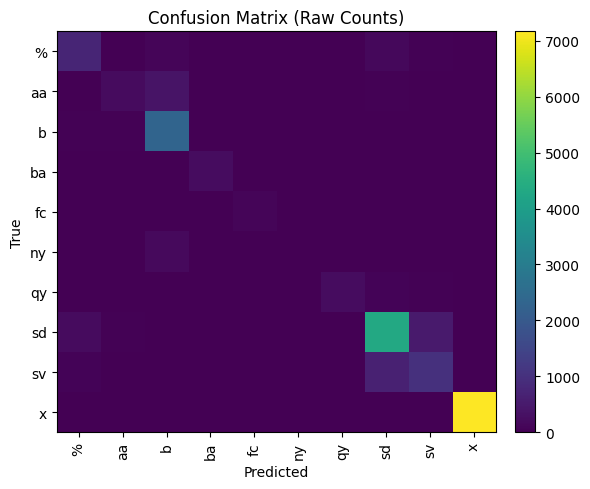

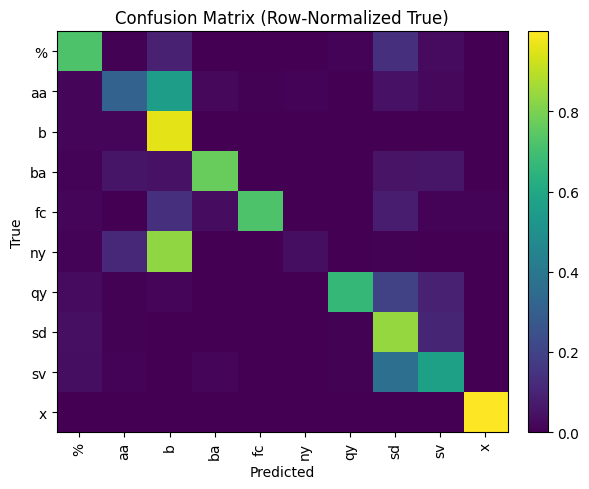

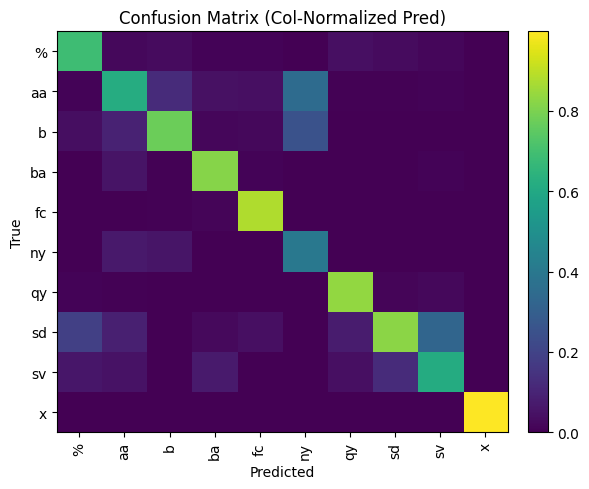

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

model.eval()
with torch.no_grad():
    logits, _ = model(speech_va, text_va)
    y_pred = torch.argmax(logits, dim=1).cpu().numpy()
    y_true = y_va_enc

labels = list(le.classes_)
num_classes = len(labels)

cm_raw  = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
cm_true = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes), normalize='true')  
cm_pred = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes), normalize='pred')  

os.makedirs("./figs", exist_ok=True)
pd.DataFrame(cm_raw,  index=labels, columns=labels).to_csv("./figs/confmat_raw.csv")
pd.DataFrame(cm_true, index=labels, columns=labels).to_csv("./figs/confmat_row_normalized.csv")
pd.DataFrame(cm_pred, index=labels, columns=labels).to_csv("./figs/confmat_col_normalized.csv")

def plot_confmat(cm, labels, title, fname):
    plt.figure(figsize=(max(6, 0.45*len(labels)), max(5, 0.45*len(labels))))
    im = plt.imshow(cm, interpolation='nearest', aspect='auto')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

plot_confmat(cm_raw,  labels, "Confusion Matrix (Raw Counts)",         "./figs/confmat_raw.png")
plot_confmat(cm_true, labels, "Confusion Matrix (Row-Normalized True)", "./figs/confmat_row_norm_true.png")
plot_confmat(cm_pred, labels, "Confusion Matrix (Col-Normalized Pred)", "./figs/confmat_col_norm_pred.png")

#### c-2. Which class(es) were easiest to predict? Why do you think they were easy?

The easiest dialogue act classes to predict were “x” (non-verbal / silence) and “sd” (statement-declarative).
In both the raw and normalized confusion matrices, these classes show strong diagonal dominance — meaning that most of their samples were correctly classified.

*	“x”  is easy because it has very distinct acoustic and textual patterns (long pauses, no lexical content, or silence markers). Both speech and text features can clearly separate it from spoken utterances.
*	“sd” is easy because it is the most frequent and lexically regular class. Declarative sentences often contain complete propositions (e.g., “I think that’s fine.”, “It looks good.”), which are easily captured by TF-IDF features and supported by steady prosody in speech.



#### c-3. Which were the most difficult? Why do you think they were difficult?


The most difficult dialogue act classes to predict were “sv” (statement-opinion), “aa” (agree/accept), and “qy” (yes–no question).
These classes show large off-diagonal areas in the normalized confusion matrices, indicating frequent misclassification.
*	“sv” (statement-opinion) is often confused with “sd” (statement-declarative) because both are complete sentences with similar syntax and prosody. The only difference lies in subtle lexical cues like opinion markers (“I think”, “maybe”), which are harder to detect, especially when prosodic cues are weak.
*	“aa” (agree/accept) overlaps with “b” (backchannel) and “ny” (yes-answer). These short affirmative responses (“yeah”, “right”, “yes”) have almost identical lexical forms and similar prosodic contours, making them challenging even for humans to distinguish.
*	“qy” (yes–no question) is also difficult because declarative questions (“You’re coming?”) share lexical patterns with statements. Without strong rising intonation or punctuation cues, models often confuse them with “sd” or “sv”.

#### c-4. What are easily confused classes? Why do you think your classifier made these errors? 

The most easily confused dialogue act pairs are (sv, sd) and (aa, b, ny), as seen from the strong off-diagonal regions in the confusion matrices.
*	sv and sd (statement-opinion vs statement-declarative)
These two are the most frequently mixed-up classes. Both are full sentences and share nearly identical lexical and prosodic forms. The main difference lies in subtle opinion or subjectivity markers (e.g., “I think”, “maybe”), which are often absent or context-dependent.
The classifier confuses them because TF-IDF and acoustic features capture surface form, not pragmatic intent.
*	aa and b and ny (agree-accept, backchannel, yes-answer)
These short utterances (“yeah”, “uh-huh”, “yes”, “right”) overlap heavily in both lexical and acoustic space. Their duration, pitch contour, and words are almost identical, so the model struggles to separate them even with prosody included.
The confusion reflects semantic and acoustic ambiguity, as well as limited context (single-word turns).
*	fc and ba (conventional closing vs appreciation)
These are low-frequency classes that the model tends to misclassify into more common polite acts.
The errors likely come from class imbalance and data sparsity — the model doesn’t see enough examples to learn reliable boundaries.

#### c-5. Based on this analysis, what ideas do you have to further improve your classifier/model?

Based on the error analysis, there are several promising directions to further improve the classifier:
1.	Add contextual modeling (dialogue history)
Many errors (e.g., aa vs b, sv vs sd) arise because the model sees each utterance in isolation.
→ Incorporating previous and next turns (e.g., via RNNs or Transformer encoders over dialogue context) could help capture pragmatic cues and turn-taking signals.

2.	Address class imbalance
Apply class-weighted loss functions or focal loss to ensure rare acts (e.g., fc, ba) are not overshadowed by frequent ones (sd, sv).
Oversampling techniques (SMOTE) or data augmentation could also balance the training set.

3.	Hierarchical or two-stage classification
Train a coarse-to-fine model:
*	Stage 1: distinguish broad dialogue act families (statement / question / feedback).
*	Stage 2: refine within each family (e.g., aa vs b vs ny).
This reduces confusion among semantically close classes.

4.	Gated or attention-based fusion (beyond simple concatenation)
Extend the fusion model to allow cross-attention between speech and text embeddings, so the model can dynamically focus on the most informative modality per utterance.

### d. Submit predictions for the Three test sets i.e., test_{UNI}_{speech, text,
multi}.csv.

#### speech

In [32]:
UNI = "jl7199"
X_te_speech, y_te_speech = get_X_y(speech_test)
base_test = pd.read_csv("./data/test.csv")

# --- train again
rf.fit(X_tr_speech, y_tr_enc)

speech_pred_enc = rf.predict(X_te_speech)
speech_pred = le.inverse_transform(speech_pred_enc)


base_test["da_tag"] = speech_pred

speech_path = f"test_{UNI}_speech.csv"
base_test.to_csv(speech_path, index=False)
print("Saved:", speech_path, base_test.shape)

Saved: test_jl7199_speech.csv (23540, 79)


#### test

In [33]:
X_te_text, y_te_text = get_X_y(text_test)

clf_text.fit(X_tr_text, y_tr_text_enc)
text_pred_enc = clf_text.predict(X_te_text)
text_pred = label_encoder_text.inverse_transform(text_pred_enc)

base_test["da_tag"] = text_pred

text_path = f"test_{UNI}_text.csv"
base_test.to_csv(text_path, index=False)
print("Saved:", text_path, base_test.shape)

Saved: test_jl7199_text.csv (23540, 79)


#### text+speech

In [34]:
joint_test = pd.concat(
    [text_test, speech_test.drop(columns=ID_COLS, errors="ignore")],
    axis=1
)

X_te_joint, y_te_joint = get_X_y(joint_test)

speech_te_tensor = torch.tensor(X_te_joint.values[:, :dim_s], dtype=torch.float32).to(device)
text_te_tensor   = torch.tensor(X_te_joint.values[:, dim_s:], dtype=torch.float32).to(device)

model.load_state_dict(torch.load("best_joint_mlp.pt", map_location=device))
model.eval()

with torch.no_grad():
    logits, _ = model(speech_te_tensor, text_te_tensor)
    pred_enc = torch.argmax(logits, dim=1).cpu().numpy()
    pred_labels = le.inverse_transform(pred_enc)

base_test["da_tag"] = pred_labels

multi_path = f"test_{UNI}_multi.csv"
base_test.to_csv(multi_path, index=False)
print("Saved:", multi_path, base_test.shape)

Saved: test_jl7199_multi.csv (23540, 79)
